In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import seaborn as sns

from keras.models import Model
from keras import optimizers
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.layers.normalization import BatchNormalization

import xgboost as xgb

Using TensorFlow backend.


In [2]:
# Here we allow access to drives directory (to load the model)

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')

data = pd.read_csv(r'/content/drive/My Drive/deep learning/assignment2/PRSA_data.csv', parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
data.drop(['No'], axis=1, inplace=True)

# Global function

In [0]:
def get_invers_transform(norm_data):
  return pd.DataFrame(min_max_norm.inverse_transform(norm_data), columns=norm_data.columns, index=norm_data.index)

def eval_rmse(X_test, y_pred, y_true):
  # invert scaling for forecast
  temp_test = X_test.copy()
  temp_test.insert(0, 'var1(t)', y_pred)
  temp_test = get_invers_transform(temp_test)
  y_pred_original_val = temp_test.iloc[:,0]
  
  # invert scaling for actual
  temp_test = X_test.copy()
  temp_test.insert(0, 'var1(t)', y_true)
  temp_test = get_invers_transform(temp_test)
  y_true_original_val = temp_test.iloc[:,0]
  
  # calculate RMSE
  rmse = mean_squared_error(y_pred_original_val, y_true_original_val) ** 0.5
  print('RMSE: %.5f' % rmse)

# Data exploratorition - part 1


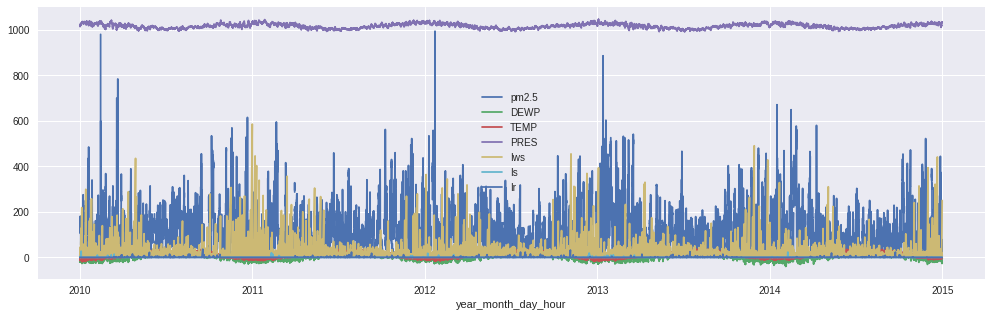

In [5]:
data.plot(figsize=(17,5))

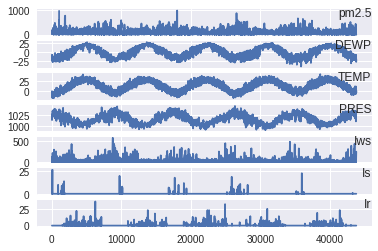

In [6]:
values = data.values

# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]

# plot each column
i = 1
plt.figure()
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(data.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

# Data preprocess

In [0]:
# drop all missing values 
data = data.dropna() 

#data.iloc[24:]
#data = data.fillna(0)

In [0]:
# hendel categorial feature 'cbwd'

le = preprocessing.LabelEncoder()
le.fit(data['cbwd'].unique())
data['cbwd'] = le.transform(data['cbwd'])

#data = pd.get_dummies(data=data, columns=['cbwd'])

In [9]:
data.head()

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
year_month_day_hour,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,2,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,2,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,2,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,2,6.25,2,0


In [10]:
min_max_norm = preprocessing.MinMaxScaler(feature_range=(0, 1))
norm_data = pd.DataFrame(min_max_norm.fit_transform(data), columns=data.columns, index=data.index)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [11]:
norm_data.head()

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
year_month_day_hour,,,,,,,,
2010-01-02 00:00:00,0.129779,0.352941,0.245902,0.527273,0.666667,0.002372,0.000000,0.0
2010-01-02 01:00:00,0.148893,0.367647,0.245902,0.527273,0.666667,0.003947,0.000000,0.0
2010-01-02 02:00:00,0.159960,0.426471,0.229508,0.545455,0.666667,0.005522,0.000000,0.0
2010-01-02 03:00:00,0.182093,0.485294,0.229508,0.563636,0.666667,0.008690,0.037037,0.0
2010-01-02 04:00:00,0.138833,0.485294,0.229508,0.563636,0.666667,0.010265,0.074074,0.0


# Data exploratorition - part 2

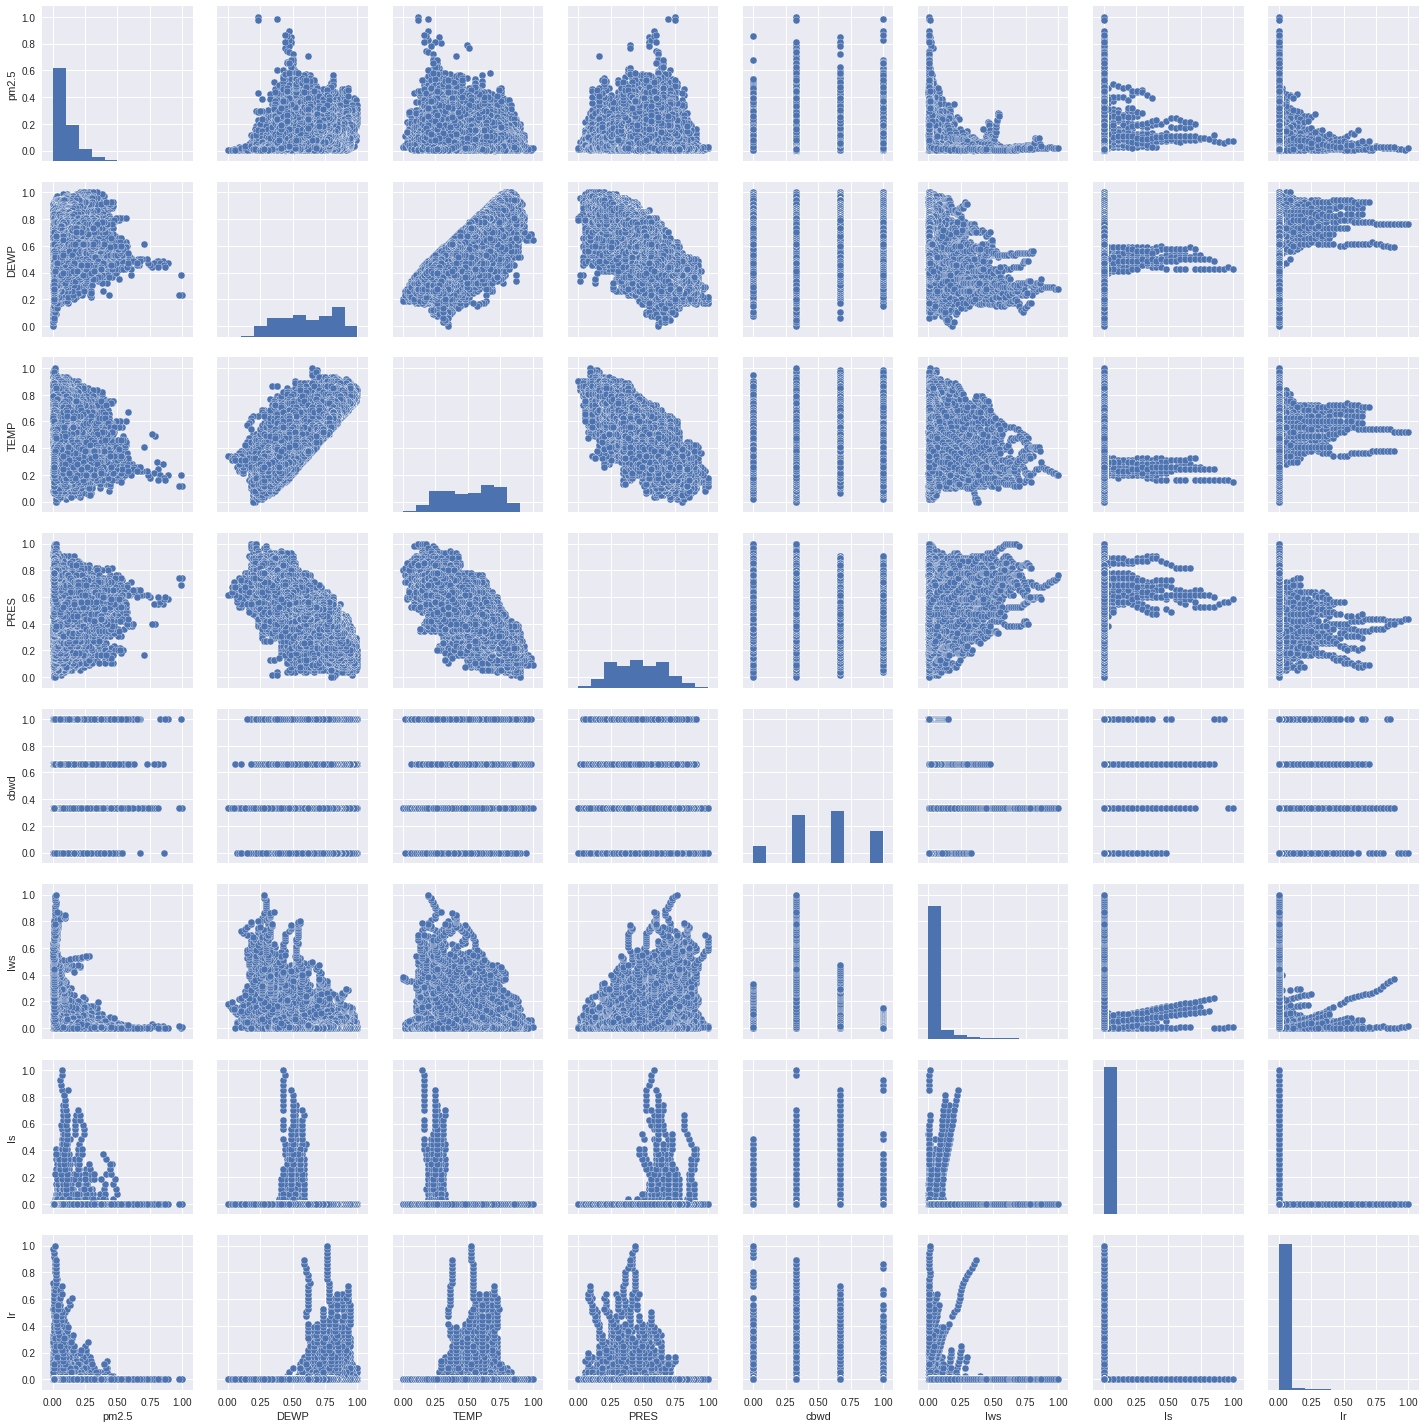

In [12]:
sns.pairplot(norm_data)

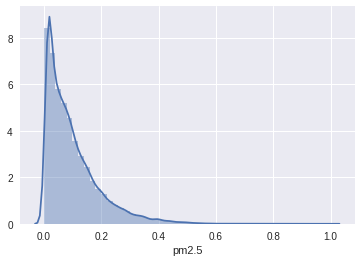

In [13]:
sns.distplot(norm_data['pm2.5'])

# Transforme the dataset into a supervised learning problem

In [0]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = data.shape[1]
	df = data
	cols, names = list(), list()
  
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
      
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
  
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
    
	return agg

In [0]:
n_hours = 48
n_features = len(norm_data.columns)
n_obs = n_hours * n_features

data_unsuper = series_to_supervised(norm_data, n_in=n_hours)

In [0]:
data_unsuper_t = data_unsuper.iloc[:, -(n_features-1):]
data_unsuper = data_unsuper.iloc[:,:-(n_features-1)]

# Split to train and test sets

In [0]:
train_idx = int(data_unsuper.shape[0]*0.8)

In [0]:
X_train = data_unsuper.iloc[:train_idx,:n_obs]
y_train = data_unsuper.iloc[:train_idx,n_obs]

X_test = data_unsuper.iloc[train_idx:,:n_obs]
y_test = data_unsuper.iloc[train_idx:,n_obs]

In [0]:
train_t = data_unsuper_t.iloc[:train_idx,:]
test_t = data_unsuper_t.iloc[train_idx:,:]

In [20]:
print('X_train shape', X_train.shape)
print('X_test shape', X_test.shape)

X_train shape (33367, 384)
X_test shape (8342, 384)


In [21]:
print('test retio', X_test.shape[0]/data_unsuper.shape[0])

test retio 0.2000047951281498


# Baseline model

In [22]:
# prediction is the mean value of the last three hours for each record

def get_prediction(data):
  x_baseline_data = data.copy()
  prediction_baseline_data = x_baseline_data[['var1(t-3)', 'var1(t-2)', 'var1(t-1)']]
  prediction_baseline_data['mean'] = prediction_baseline_data.loc[:,:].mean(axis=1)
  return prediction_baseline_data['mean']

y_baseline_pred_train = get_prediction(X_train)
y_baseline_pred_test = get_prediction(X_test)

print('TRAIN RMSE:')
eval_rmse(X_train.iloc[:,-7:], y_baseline_pred_train, y_train)
print('TEST RMSE:')
eval_rmse(X_test.iloc[:,-7:], y_baseline_pred_test, y_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


TRAIN RMSE:
RMSE: 34.09568
TEST RMSE:
RMSE: 29.92891


# Classical ML model - XGB

In [23]:
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75, colsample_bytree=1, max_depth=4)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.08, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.75)

In [0]:
xgb_pred_train = xgb_model.predict(X_train)
xgb_pred_test = xgb_model.predict(X_test)

In [25]:
print('TRAIN RMSE:')
eval_rmse(train_t, xgb_pred_train, y_train)
print('TEST RMSE:')
eval_rmse(test_t, xgb_pred_test, y_test)

TRAIN RMSE:
RMSE: 20.84794
TEST RMSE:
RMSE: 21.60284


# LSTM model


In [0]:
# split to train and validation sets

val_idx = int(X_train.shape[0]*0.8)
X_train_val = X_train.iloc[:val_idx,:]
y_train_val = y_train.iloc[:val_idx]

X_val = X_train.iloc[val_idx:,:]
y_val = y_train.iloc[val_idx:]

train_val_t = train_t.iloc[:val_idx,:]
val_t = train_t.iloc[val_idx:,:]

In [0]:
# reshape input to be 3D [samples, timesteps, features]

X_train_3d = X_train_val.values.reshape((X_train_val.shape[0], n_hours, n_features))
X_val_3d = X_val.values.reshape((X_val.shape[0], n_hours, n_features))
X_test_3d = X_test.values.reshape((X_test.shape[0], n_hours, n_features))

In [0]:
model = Sequential()
model.add(LSTM(50, input_shape=(X_train_3d.shape[1], X_train_3d.shape[2])))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')

In [29]:
history = model.fit(X_train_3d, y_train_val, epochs=50, batch_size=72, validation_data=(X_val_3d, y_val), verbose=2, shuffle=False)

Train on 26693 samples, validate on 6674 samples
Epoch 1/50
 - 15s - loss: 0.0361 - val_loss: 0.0226
Epoch 2/50
 - 14s - loss: 0.0203 - val_loss: 0.0172
Epoch 3/50
 - 14s - loss: 0.0166 - val_loss: 0.0134
Epoch 4/50
 - 14s - loss: 0.0149 - val_loss: 0.0142
Epoch 5/50
 - 14s - loss: 0.0143 - val_loss: 0.0122
Epoch 6/50
 - 14s - loss: 0.0138 - val_loss: 0.0121
Epoch 7/50
 - 14s - loss: 0.0137 - val_loss: 0.0121
Epoch 8/50
 - 14s - loss: 0.0137 - val_loss: 0.0122
Epoch 9/50
 - 14s - loss: 0.0136 - val_loss: 0.0118
Epoch 10/50
 - 14s - loss: 0.0141 - val_loss: 0.0116
Epoch 11/50
 - 15s - loss: 0.0136 - val_loss: 0.0116
Epoch 12/50
 - 14s - loss: 0.0137 - val_loss: 0.0118
Epoch 13/50
 - 14s - loss: 0.0137 - val_loss: 0.0118
Epoch 14/50
 - 14s - loss: 0.0138 - val_loss: 0.0120
Epoch 15/50
 - 14s - loss: 0.0136 - val_loss: 0.0118
Epoch 16/50
 - 14s - loss: 0.0136 - val_loss: 0.0119
Epoch 17/50
 - 14s - loss: 0.0136 - val_loss: 0.0118
Epoch 18/50
 - 14s - loss: 0.0135 - val_loss: 0.0118
Epoch 

# Predictions

In [0]:
test_lstm_pred = model.predict(X_test_3d)

In [31]:
eval_rmse(test_t, test_lstm_pred, y_test) #X_test

RMSE: 21.54624


In [0]:
train_lstm_pred = model.predict(X_train_3d)

In [33]:
eval_rmse(train_val_t, train_lstm_pred, y_train_val) #X_train_2

RMSE: 24.82923


In [0]:
val_lstm_pred = model.predict(X_val_3d)

In [35]:
eval_rmse(val_t, val_lstm_pred, y_val) #X_val

RMSE: 19.56271


# Plots

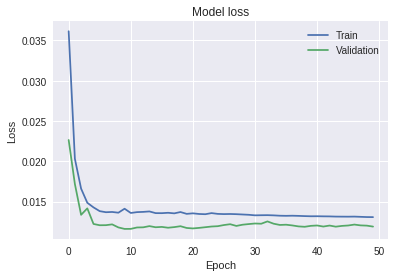

In [36]:
# plotting loss function

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# TEST SET PLOTS

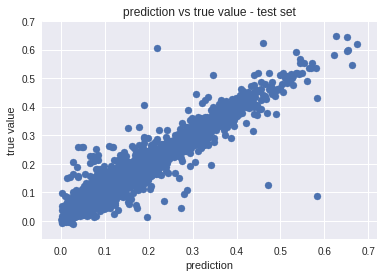

In [37]:
# plotting prediction vs true value on test set

plt.scatter(y_test,test_lstm_pred)
plt.title("prediction vs true value - test set")
plt.xlabel("prediction")
plt.ylabel("true value")
plt.show()

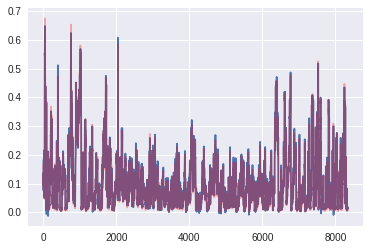

In [38]:
plt.plot(test_lstm_pred[:,0])
plt.plot(y_test.values,c='red',alpha=0.3)

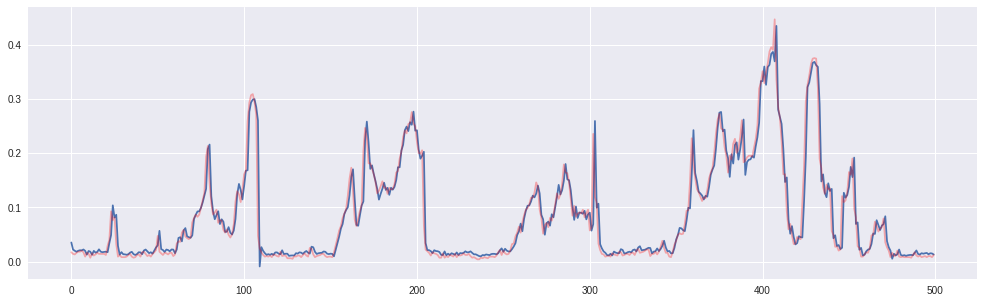

In [57]:
plt.figure(figsize=(17,5))
plt.plot(test_lstm_pred[-500:,0])
plt.plot(y_test.iloc[-500:,].values,c='red',alpha=0.3)

# TRAIN SET PLOTS

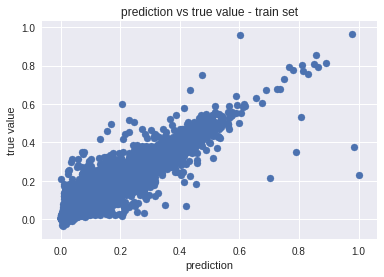

In [39]:
# plotting prediction vs true value on train set

plt.scatter(y_train_val,train_lstm_pred)
plt.title("prediction vs true value - train set")
plt.xlabel("prediction")
plt.ylabel("true value")
plt.show()

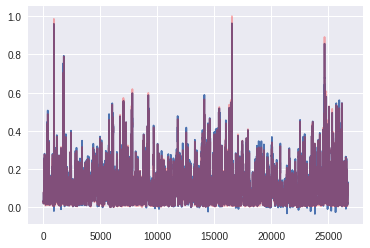

In [40]:
plt.plot(train_lstm_pred[:,0])
plt.plot(y_train_val.values,c='red',alpha=0.3)

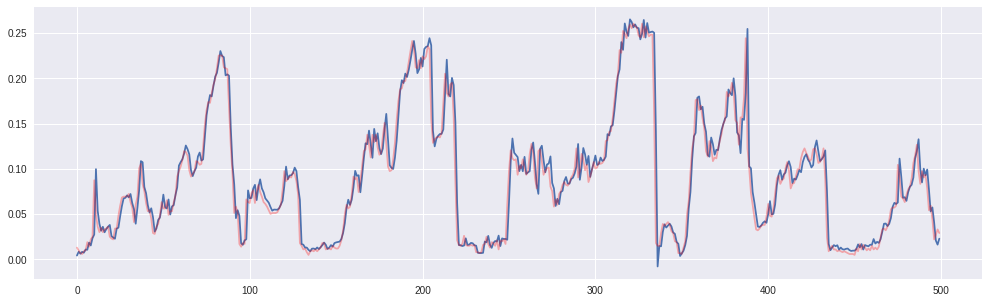

In [58]:
plt.figure(figsize=(17,5))
plt.plot(train_lstm_pred[-500:,0])
plt.plot(y_train_val.iloc[-500:,].values,c='red',alpha=0.3)

# VALIDATION SET PLOTS

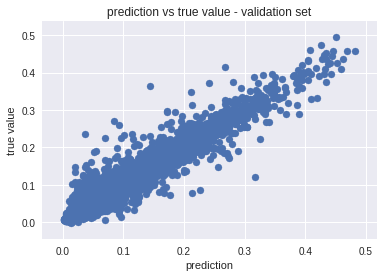

In [41]:
# plotting prediction vs true value on validation set

plt.scatter(y_val,val_lstm_pred)
plt.title("prediction vs true value - validation set")
plt.xlabel("prediction")
plt.ylabel("true value")
plt.show()

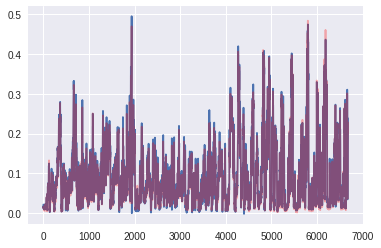

In [42]:
plt.plot(val_lstm_pred[:,0])
plt.plot(y_val.values,c='red',alpha=0.3)

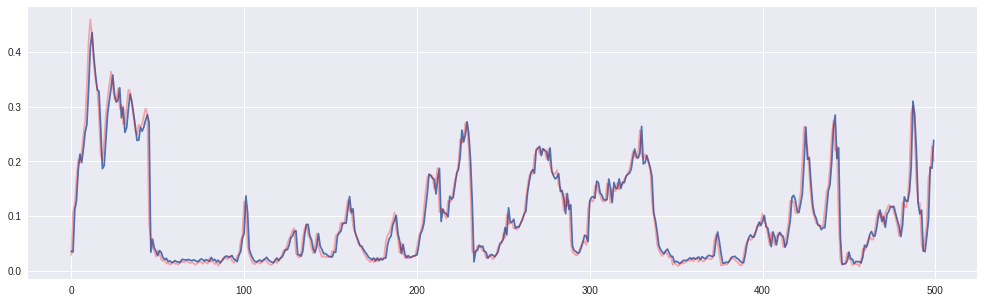

In [59]:
plt.figure(figsize=(17,5))
plt.plot(val_lstm_pred[-500:,0])
plt.plot(y_val.iloc[-500:,].values,c='red',alpha=0.3)